<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

In [1]:
pip list

In [2]:
!pip install scikit-learn==1.0.2

In [3]:
import pandas as pd
import numpy as np
 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
from seaborn import kdeplot
import matplotlib.pyplot as plt

import time
import timeit
from datetime import datetime
from tqdm import tqdm
import os

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Коснстанты
RS = 42 #random state
TS = 0.1 # test size 10%
POROG_TEST = 48 #

## Подготовка

### Загрузка и сортировка данных

In [5]:
# Загружаем данные
pth1 = '/datasets/taxi.csv'
pth2 = 'taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col='datetime', parse_dates=['datetime'])
    
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col='datetime', parse_dates=['datetime'])
    
else:
    print('Ошибка загрузки данных, проверьте правильность пути, наличие файла')

In [6]:
#print(data.index.is_monotonic)

In [7]:
# Сортировка и вывод данных
df.sort_index(inplace=True)
display(df.head(), df.tail(), df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


None

In [8]:
# Проверка сотрировки
df.index.is_monotonic

True

###  Ресемплирование данных по одному часу

In [9]:
df = df.resample('1H').sum()
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


(                     num_orders
 datetime                       
 2018-03-01 00:00:00         124
 2018-03-01 01:00:00          85
 2018-03-01 02:00:00          71
 2018-03-01 03:00:00          66
 2018-03-01 04:00:00          43,
 None)

In [10]:
df.isna().sum()

num_orders    0
dtype: int64

### Вывод
 
Исходные данные содержат сумму заказов такси за 10 минут. 
Всего записей 26496.
Тип данных подходит для анализа.
Данные были ресемплированы по одному часу.  
осставшееся количество записей сократилось до 4416.  
Данных достаточно для анализа.  
Рассматриваемый период с 2018-03-01 00:00:00 до 2018-08-31 23:00:00.

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b> 
    
С данными познакомились, проведен первичный аналитический осмотр!) Отлично, что проведено ресемплирование с использованием суммы. Полученная информация поможет нам в дальнейшем с предобработкой данных

## Анализ

### Исходные данные

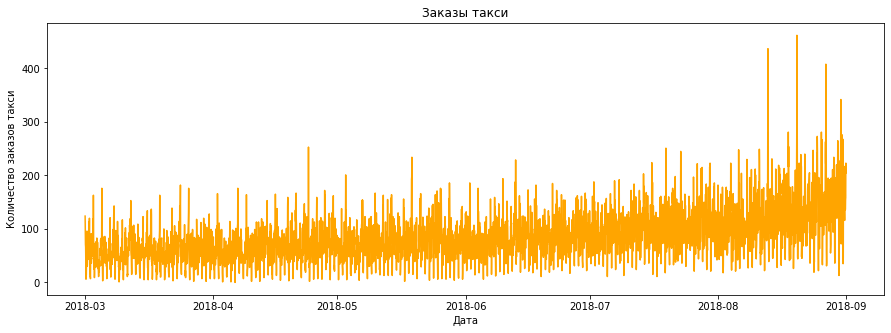

In [11]:
# График исходного ряда
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['num_orders'], color = 'orange')
plt.title('Заказы такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

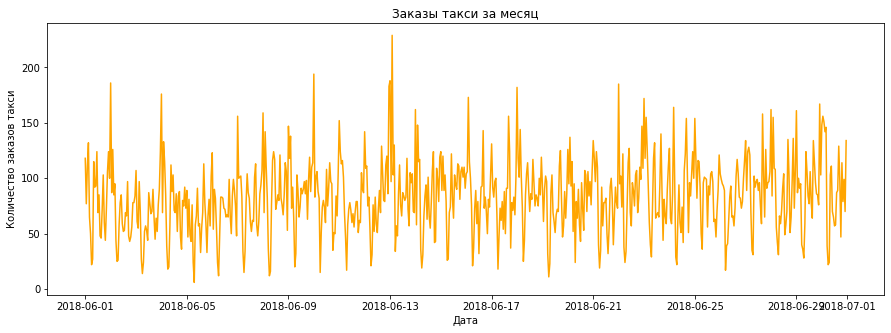

In [12]:
# Срез месяц
df_month = df['2018-06-01':'2018-06-30']
plt.figure(figsize=(15, 5))
plt.plot(df_month.index, df_month['num_orders'], color = 'orange')
plt.title('Заказы такси за месяц')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

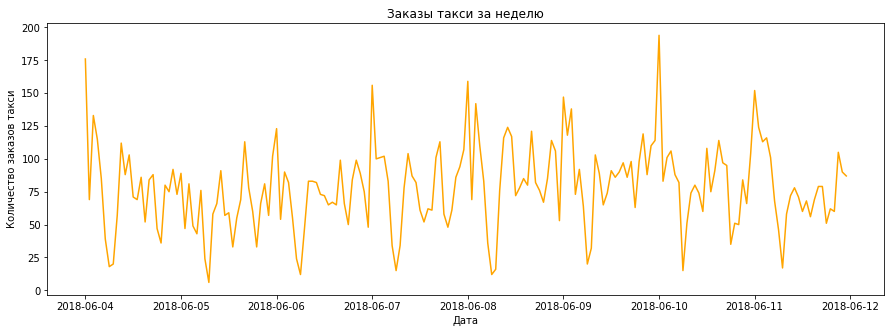

In [13]:
# Срез неделя
df_week = df['2018-06-04':'2018-06-11']

plt.figure(figsize=(15, 5))
plt.plot(df_week.index, df_week['num_orders'], color = 'orange')
plt.title('Заказы такси за неделю')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

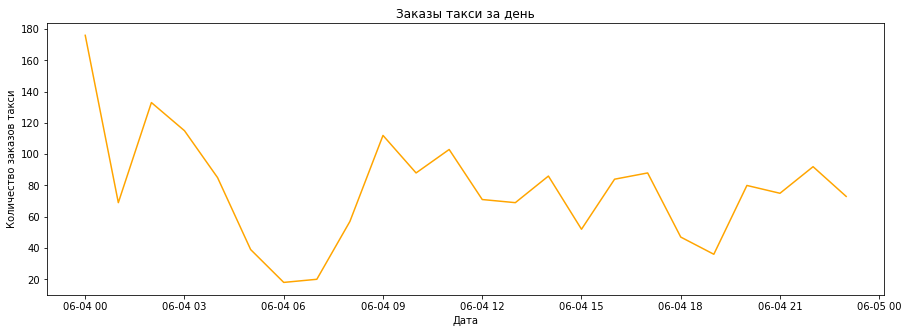

In [14]:
# Срез произвольный день
df_day = df['2018-06-04':'2018-06-04']

plt.figure(figsize=(15, 5))
plt.plot(df_day.index, df_day['num_orders'], color = 'orange')
plt.title('Заказы такси за день')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

### Вывод

Есть периодические всплески количества заказов, указывающие на какие-то события, определенные дни - выходные или праздники.
Полученный график показывает, что количество заказов такси со временем медленно увеличивается, тренд становится более явным с приходом лета, видимо, это связано с сезоном отпусков: в частности, люди чаще летают и, соответственно, чаще заказывают такси.  
Временной ряд нестационарен: дисперсия и среднее увеличиваются.  
Данные с некоторой ежедневной и еженедельной сезонностью. 

### Дополнительные признаки

In [15]:
df.shape

(4416, 1)

#### Календарные признаки 

In [16]:
# Сформируем дополнительные календарные признаки 
df['hour'] = df.index.hour # для учета зависимости числа заказов от номера часа в сутках
df['weekday'] = df.index.weekday # для учета сезонности по дням 
df['weekend'] = df.index.weekday.isin([5,6]) * 1 # для учета сезонности по выходным дням 

In [17]:
# Проверка добавления признаков
display(df[:3], df.tail(3))

,num_orders,hour,weekday,weekend
datetime,,,,
2018-03-01 00:00:00,124,0,3,0
2018-03-01 01:00:00,85,1,3,0
2018-03-01 02:00:00,71,2,3,0


,num_orders,hour,weekday,weekend
datetime,,,,
2018-08-31 21:00:00,159,21,4,0
2018-08-31 22:00:00,223,22,4,0
2018-08-31 23:00:00,205,23,4,0


#### Средние

In [18]:
# Сформируем дополнительный признак 
# cкользящее среднее числа заказов такси с окном сглаживания 24 часа: (задает общий тренд временного ряда)
df['rolling_mean'] = df['num_orders'].shift().rolling(window=24).mean()

In [19]:
# Дополнительный признак средняя заказов в каджом часе

# индекс последнего элемента в обучающем наборе
last_index_test  = int(len(df)*(1-TS))

# формирование признака средняя по группе: заполнение средним значение по группе признака hour
by_hour_mean = dict(df[:last_index_test].groupby('hour')['num_orders'].mean())
df['by_hour_mean'] = list(map(by_hour_mean.get, df.hour))

#### Отстающие значения

In [20]:
# Сформируем дополнительные признаки: отстающие 7 значений 
for lag in range(1, 7):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

In [21]:
# Проверка добавления признаков
display(df[:26], df.tail(3))

,num_orders,hour,weekday,weekend,rolling_mean,by_hour_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,0,NaN,135.915663,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,0,NaN,95.734940,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,0,NaN,103.240964,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,0,NaN,94.385542,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,0,NaN,77.939759,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,5,3,0,NaN,39.451807,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,6,3,0,NaN,22.951807,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 07:00:00,15,7,3,0,NaN,27.439759,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 08:00:00,34,8,3,0,NaN,68.228916,15.0,12.0,6.0,43.0,66.0,71.0


,num_orders,hour,weekday,weekend,rolling_mean,by_hour_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,
2018-08-31 21:00:00,159,21,4,0,168.041667,88.575758,154.0,136.0,207.0,217.0,197.0,116.0
2018-08-31 22:00:00,223,22,4,0,166.416667,92.957576,159.0,154.0,136.0,207.0,217.0,197.0
2018-08-31 23:00:00,205,23,4,0,169.125000,102.103030,223.0,159.0,154.0,136.0,207.0,217.0


In [22]:
# Удаление пропусков
df = df.dropna()

In [23]:
# Проверка таблицы данных после преобразований
display(df[:26], df.tail(3), df.shape)

,num_orders,hour,weekday,weekend,rolling_mean,by_hour_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,0,56.833333,135.915663,58.0,113.0,66.0,61.0,45.0,73.0
2018-03-02 01:00:00,120,1,4,0,55.416667,95.734940,90.0,58.0,113.0,66.0,61.0,45.0
2018-03-02 02:00:00,75,2,4,0,56.875000,103.240964,120.0,90.0,58.0,113.0,66.0,61.0
2018-03-02 03:00:00,64,3,4,0,57.041667,94.385542,75.0,120.0,90.0,58.0,113.0,66.0
2018-03-02 04:00:00,20,4,4,0,56.958333,77.939759,64.0,75.0,120.0,90.0,58.0,113.0
2018-03-02 05:00:00,11,5,4,0,56.000000,39.451807,20.0,64.0,75.0,120.0,90.0,58.0
2018-03-02 06:00:00,11,6,4,0,56.208333,22.951807,11.0,20.0,64.0,75.0,120.0,90.0
2018-03-02 07:00:00,7,7,4,0,56.166667,27.439759,11.0,11.0,20.0,64.0,75.0,120.0
2018-03-02 08:00:00,46,8,4,0,55.833333,68.228916,7.0,11.0,11.0,20.0,64.0,75.0


,num_orders,hour,weekday,weekend,rolling_mean,by_hour_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,
2018-08-31 21:00:00,159,21,4,0,168.041667,88.575758,154.0,136.0,207.0,217.0,197.0,116.0
2018-08-31 22:00:00,223,22,4,0,166.416667,92.957576,159.0,154.0,136.0,207.0,217.0,197.0
2018-08-31 23:00:00,205,23,4,0,169.125000,102.103030,223.0,159.0,154.0,136.0,207.0,217.0


(4392, 12)

### Вывод

Сформированы дополнительные признаки ввиду размера выборки для анализа и горизонта прогноза в 1 час.  

Календарные признаки - так как периодические всплески наблюдаются каждцю неделю и месяц, а в днях наблюдаются пики и спады.  
'hour' номер часа в сутках  
'weekday' номер дня недели  
'weekend' выходной день   
 
Средние  
'rolling_mean' - скользящее среднее - оно отражает характеристики тренда  
'by_hour_mean' - средняя по группе час - данным признаком заменим признак hour для большей информативности при обучении  
Признаки отстающих значений  
6 штук - lag_1 по lag_6  
Всего признаков для анализа 11, т.к. hour заменен средним по группе час.    
Пропуски посе преобразований были удалены.  
Построены и проанализированы графики.   
От месяца к месяцу тренд на увеличение заказов такси.

### Графики

#### Тренд и сезонность

In [24]:
# Cезонные составляющие ряда
result = seasonal_decompose(df['num_orders'], model='additive', period=24*7)

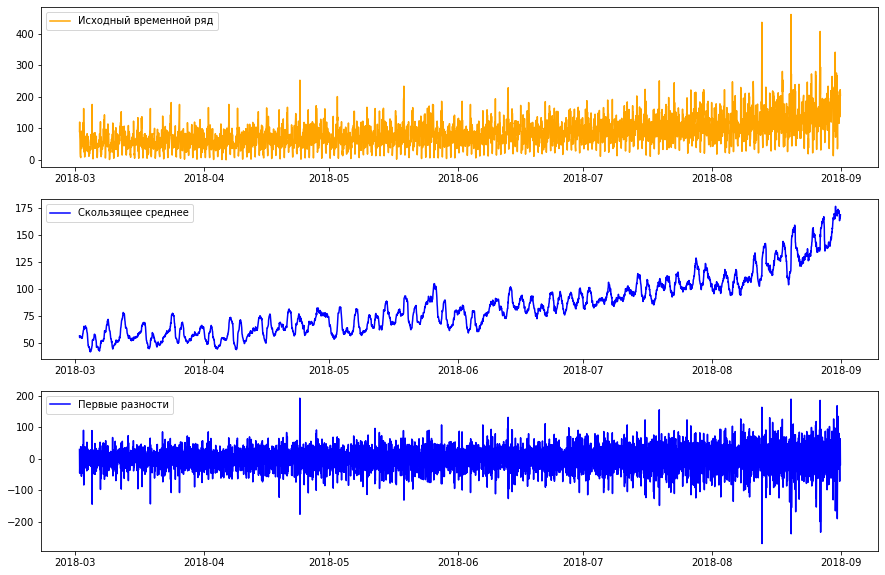

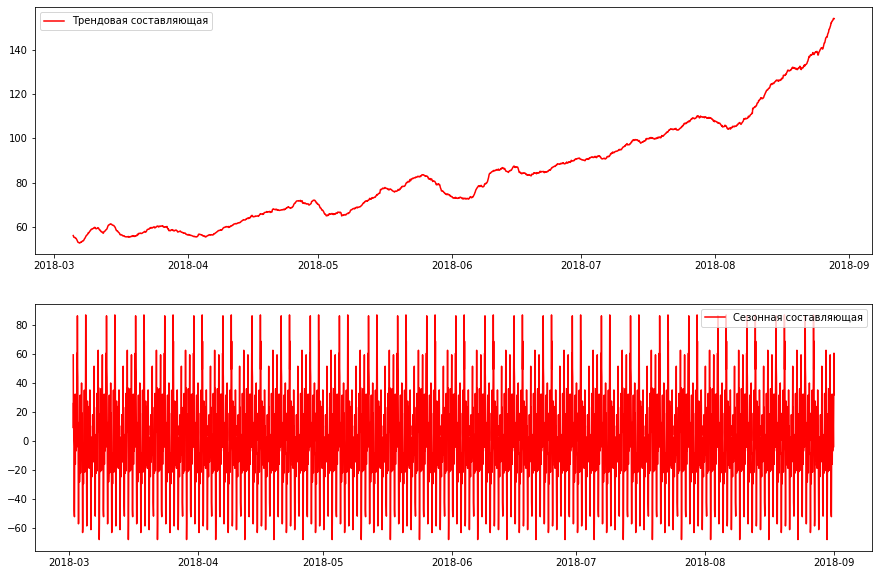

In [25]:
# Построим графики:
plt.figure(figsize=(15,10))

# Исходный временной ряд
plt.subplot(311)
plt.plot(df.index, df['num_orders'], label='Исходный временной ряд', color='orange')
plt.legend(loc='best')

# Скользящее среднее
plt.subplot(312)
plt.plot(df.index, df['rolling_mean'], label='Скользящее среднее', color='blue')
plt.legend(loc='best')

# Разности
diff = df['num_orders'].diff()
plt.subplot(313)
plt.plot(df.index, diff, label='Первые разности', color='blue')
plt.legend(loc='best')
plt.axis('tight')
plt.show()

plt.figure(figsize=(15,10))

# Трендовая составляющая
plt.subplot(211)
plt.plot(df.index, result.trend, label='Трендовая составляющая', color='red')
plt.legend(loc='best')

# Сезонность
plt.subplot(212)
plt.plot(df.index, result.seasonal, label='Сезонная составляющая', color='red')
plt.legend(loc='best')

plt.show()

Графики отображают возрастающий тренд заказов такси и сезонную составляющую. 

От месяца к месяцу тренд на увеличение заказов такси.

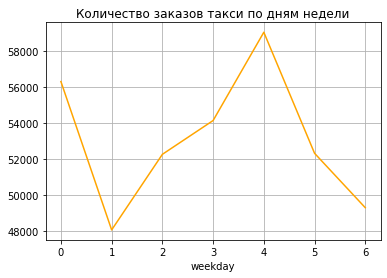

In [26]:
# Количество заказов такси по дням недели 
df.groupby('weekday')['num_orders'].sum().plot(color='orange')
plt.title('Количество заказов такси по дням недели')
plt.grid(True)
plt.show()

По понедельникам и четвергам спрос максимальный, по вторникам и воскресеньям - минимальный.

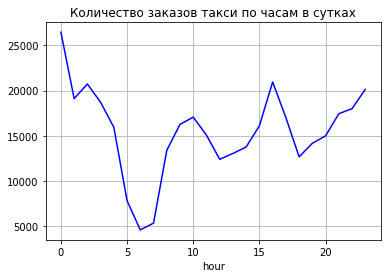

In [27]:
# Количество заказов такси по часам в сутках 
df.groupby('hour')['num_orders'].sum().plot(color='blue')
plt.title('Количество заказов такси по часам в сутках')
plt.grid(True)
plt.show()

In [28]:
# Удаляем закодированный средним признак 
df.drop(['hour'], axis=1, inplace=True)

### Вывод
Сформированы дополнительные признаки ввиду размера выборки для анализа и горизонта прогноза в 1 час.  

Календарные признаки - так как периодические всплески наблюдаются каждцю неделю и месяц, а в днях наблюдаются пики и спады.  
 номер часа в сутках  
 номер дня недели  
 выходной день   
 месяц  
скользящее среднее - оно отражает характеристики тренда  
средняя по группе час - данным признаком заменим признак hour для большей информативности при обучении  
Признаки отстающих значений  6 штук   

Всего признаков для анализа 11, т.к. hour заменен средним по группе час.    

Пропуски посе преобразований были удалены.  
Построены и проанализированы графики.   
От месяца к месяцу тренд на увеличение заказов такси.  

Максимальное количество заказов около 00 часов: активный рост заказов начинается с 17 часов.   
Пик сменяется активным падением заказов: минимальное количество заказов приходится на 6 утра. 
С 7 до 10 часов рост заказов. Пики также в 16 часов. Это связано скорее всего и с расписанием прилетов.  
Ожидаемо, что в ночные часы такси пользуется спросом у клиентов.

### Подготовка выборок

In [29]:
# Подготовка выборок: тестовая 10%
test_size = 0.1
train, test = train_test_split(df, shuffle=False, test_size=test_size, random_state=RS)

# Выделим целевой и остальные признаки
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

# Проверка выборок
print(f'Размер обучающей выборки: {train.shape}  \n \nРазмер тестовой выборки: {test.shape}\n\n')
print(f' Обучающая выборка:\n\n')
display(train.head(3), train.tail(3), train.info())
print(f' Тестовая выборка:\n\n')
display(test.head(3), test.tail(3), test.info())

Размер обучающей выборки: (3952, 11)  
 
Размер тестовой выборки: (440, 11)


 Обучающая выборка:


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3952 entries, 2018-03-02 00:00:00 to 2018-08-13 15:00:00
Freq: H
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3952 non-null   int64  
 1   weekday       3952 non-null   int64  
 2   weekend       3952 non-null   int64  
 3   rolling_mean  3952 non-null   float64
 4   by_hour_mean  3952 non-null   float64
 5   lag_1         3952 non-null   float64
 6   lag_2         3952 non-null   float64
 7   lag_3         3952 non-null   float64
 8   lag_4         3952 non-null   float64
 9   lag_5         3952 non-null   float64
 10  lag_6         3952 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 370.5 KB


,num_orders,weekday,weekend,rolling_mean,by_hour_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,56.833333,135.915663,58.0,113.0,66.0,61.0,45.0,73.0
2018-03-02 01:00:00,120,4,0,55.416667,95.734940,90.0,58.0,113.0,66.0,61.0,45.0
2018-03-02 02:00:00,75,4,0,56.875000,103.240964,120.0,90.0,58.0,113.0,66.0,61.0


,num_orders,weekday,weekend,rolling_mean,by_hour_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,
2018-08-13 13:00:00,119,0,0,138.583333,67.343373,92.0,144.0,156.0,137.0,91.0,39.0
2018-08-13 14:00:00,102,0,0,138.541667,69.945455,119.0,92.0,144.0,156.0,137.0,91.0
2018-08-13 15:00:00,175,0,0,138.458333,81.672727,102.0,119.0,92.0,144.0,156.0,137.0


None

 Тестовая выборка:


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 440 entries, 2018-08-13 16:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    440 non-null    int64  
 1   weekday       440 non-null    int64  
 2   weekend       440 non-null    int64  
 3   rolling_mean  440 non-null    float64
 4   by_hour_mean  440 non-null    float64
 5   lag_1         440 non-null    float64
 6   lag_2         440 non-null    float64
 7   lag_3         440 non-null    float64
 8   lag_4         440 non-null    float64
 9   lag_5         440 non-null    float64
 10  lag_6         440 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 41.2 KB


,num_orders,weekday,weekend,rolling_mean,by_hour_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,
2018-08-13 16:00:00,144,0,0,139.541667,107.321212,175.0,102.0,119.0,92.0,144.0,156.0
2018-08-13 17:00:00,152,0,0,139.166667,82.836364,144.0,175.0,102.0,119.0,92.0,144.0
2018-08-13 18:00:00,104,0,0,140.708333,63.412121,152.0,144.0,175.0,102.0,119.0,92.0


,num_orders,weekday,weekend,rolling_mean,by_hour_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,
2018-08-31 21:00:00,159,4,0,168.041667,88.575758,154.0,136.0,207.0,217.0,197.0,116.0
2018-08-31 22:00:00,223,4,0,166.416667,92.957576,159.0,154.0,136.0,207.0,217.0,197.0
2018-08-31 23:00:00,205,4,0,169.125000,102.103030,223.0,159.0,154.0,136.0,207.0,217.0


None

In [30]:
# Список качественных признаков
ohe_features = ['weekday']

# Список количественных признаков для преобразований
num_features = list(X_train.columns.difference(ohe_features))

print(num_features)

['by_hour_mean', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'rolling_mean', 'weekend']


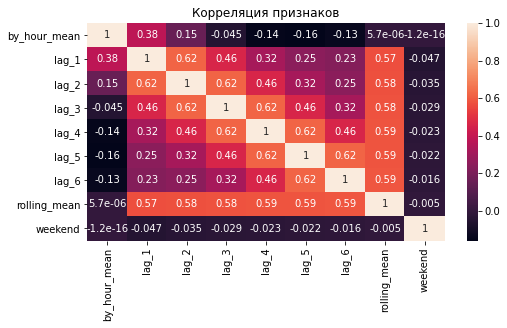

In [31]:
# Тепловая карта матрицы корреляции
plt.figure(print(), figsize=(8, 4)), sns.heatmap(df[num_features].corr(), annot=True)
plt.title(f'Корреляция признаков')
plt.show()

### Вывод

Были подготовлены обучающая и тестовая выборки для обучения моделей.   
Выделен целевой признак 'num_orders' - количество заказов такси в час.  
По условиям заказчика тестовая выборка составила 10% исходных данных - около 2х недель: с 2018-08-13 16:00:00 по 2018-08-31 23:00:00.    

Размер обучающей выборки: (3952, 12)    
Размер тестовой выборки: (440, 12)  
Оценена корреляция: мультиколлинеарных признаков нет.

## Обучение

### Подготовим выборки

In [32]:
# Количество разбиений для TimeSeriesSplit
n_splits = 5

# Создаем объект TimeSeriesSplit
cv_iterator = list(TimeSeriesSplit(n_splits=n_splits).split(X_train))

In [33]:
# Функция для получения лучших параметров (из заданных для них диапазонов) указанной модели
# На вход подется модель машинного обучения и словарь параметров с заданным диапазоном, выборка для обучения
# На выходе получаем модель с лучшими параметрами по заданной метрике, обученную на выборке train, 
# и заданную метрику (rsme)

def best_model (model, param_dict, features, targets):
   
    model_rs = RandomizedSearchCV(estimator=model, \
                                  param_distributions=param_dict, \
                                  n_iter=10, cv=cv_iterator, \
                                  n_jobs=-1, verbose=1, \
                                  scoring='neg_root_mean_squared_error') 
    model_rs = model_rs.fit(features, targets)
    best_model = model_rs.best_estimator_
    best_params = model_rs.best_params_
    best_score = model_rs.best_score_*-1  
    fit_time = model_rs.refit_time_ # время обучения лучшей модели на всей выборке train
    # время предсказания на выборке train 
    start_time = time.time()
    predict = best_model.predict(features)
    end_time = time.time()
    predict_time = end_time - start_time
    return {'best_model': best_model, 'best_params': best_params,'predict': predict, 'best_score': best_score, \
            'fit_time': fit_time, 'predict_time': predict_time}

In [34]:
# Предобработчик данных для пайплайнов для линейных моделей

preprocessor_linear = make_column_transformer(
    
    (MinMaxScaler(), num_features),  
    (OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_features),
    remainder='passthrough',
    verbose_feature_names_out=False #(будет True по умолчанию)
)

In [35]:
# Словарь для сохранения результатов обучения моделей
results = {}

In [36]:
# Функция, сопоставляющая прогнозируемые значения с фактическими 
# входящие аргументы : название модели, фактические целевые значения - y,  флаг тестовоя ли быборка
def plot_prediction(name_model, y, sample_test=False):
    #rmse = np.sqrt(mean_squared_error(y, prediction)) # model_result['best_model'].predict(X_test)
    if sample_test:
        prediction = best_predict
        rmse = rmse_best_model
    else:
        prediction = results[name_model]['predict']
        rmse = results[name_model]['best_score']
    
    y_series = pd.Series(y.values, index=y.index)
    prediction_series = pd.Series(prediction, index=y.index)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction_series, "r", label="Предсказания")
    plt.plot(y_series, label="Фактические значения", color='blue')
    plt.legend(loc="best")
    plt.title(f"Предсказания и фактические значения {name_model} RMSE: {rmse:.2f}")
    plt.grid(True)
    plt.show()
    # график по срезу в последние 14 дней
    plt.figure(figsize=(15, 7))
    plt.plot(prediction_series[-7*24:], "r", label="Предсказания")
    plt.plot(y_series[-7*24:], label="Фактические значения", color='blue')
    plt.legend(loc="best")
    plt.title(f"Предсказания и фактические значения {name_model} за последние 14 дней RMSE: {rmse:.2f}")
    plt.grid(True)
    plt.show()

#### LGBMRegressor

In [37]:
# Пайплайн для RandomForestRegressor и ее параметры

model_lgbm = LGBMRegressor(random_state=RS)

pipe_lgbm = make_pipeline(preprocessor_linear, model_lgbm)

param_lgbm = {'lgbmregressor__learning_rate': [0.1, 0.3],
              'lgbmregressor__n_estimators': range(2, 50)
} 

In [38]:
%%time
# Подбираем модель c лучшими гиперпараметрами по rmse, получаем оценку качества, время обучения, время предсказания 

best_model_lgbm = best_model(pipe_lgbm, param_lgbm, X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 14.6 s, sys: 65.2 ms, total: 14.7 s
Wall time: 14.8 s


In [39]:
results['LGBMRegressor'] = best_model_lgbm
results['LGBMRegressor']

{'best_model': Pipeline(steps=[('columntransformer',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('minmaxscaler',
                                                   MinMaxScaler(),
                                                   ['by_hour_mean', 'lag_1',
                                                    'lag_2', 'lag_3', 'lag_4',
                                                    'lag_5', 'lag_6',
                                                    'rolling_mean', 'weekend']),
                                                  ('onehotencoder',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore'),
                                                   ['weekday'])],
                                    verbose_feature_names_out=False)),
                 ('lgbmregressor',
                  LGBMRegressor(n_e

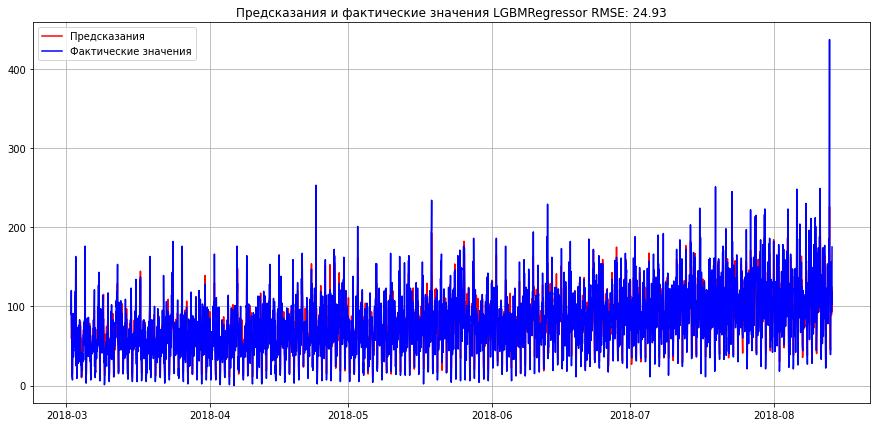

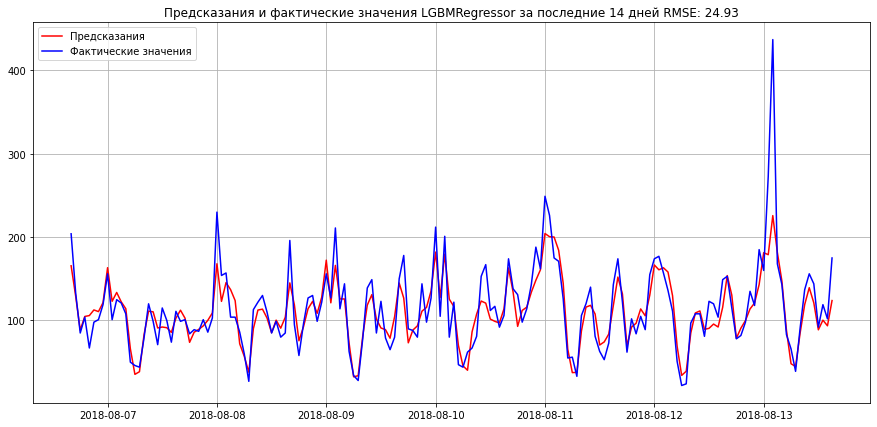

In [40]:
plot_prediction('LGBMRegressor', y_train)

#### RandomForestRegressor

In [41]:
# Пайплайн для RandomForestRegressor и ее параметры

model_rf = RandomForestRegressor(random_state=RS)

pipe_rf = make_pipeline(preprocessor_linear, model_rf)

param_rf = {
    'randomforestregressor__max_depth': [4], 
    'randomforestregressor__n_estimators': range(2, 50) # range(150, 250, 50)
}

In [42]:
%%time
# Подбираем модель c лучшими гиперпараметрами по rmse, получаем оценку качества, время обучения, время предсказания 

best_model_rf = best_model(pipe_rf, param_rf, X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 5.97 s, sys: 33.6 ms, total: 6 s
Wall time: 6.12 s


In [43]:
results['RandomForestRegressor'] = best_model_rf
#results['RandomForestRegressor']

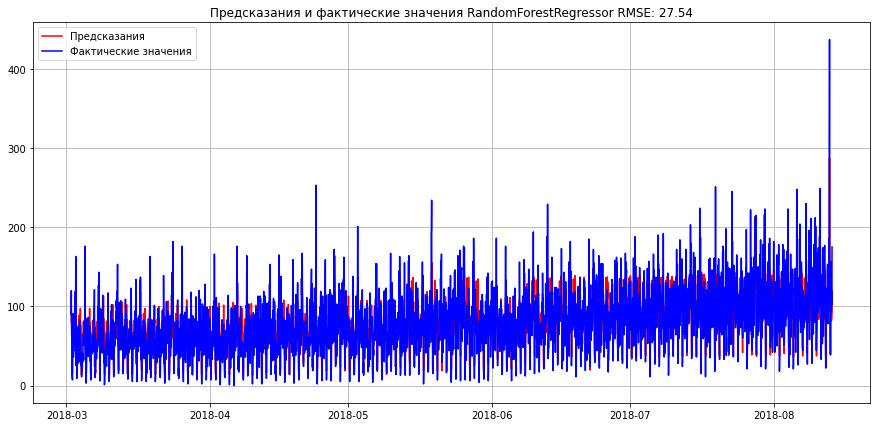

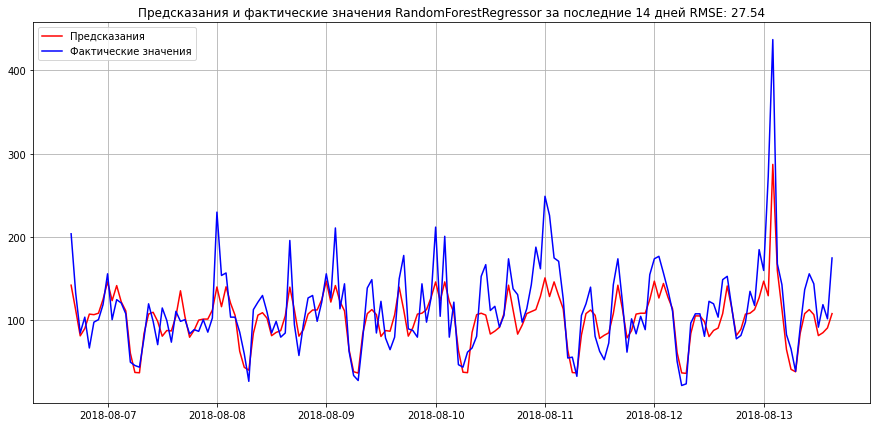

In [44]:
plot_prediction('RandomForestRegressor', y_train)

#### Ridge

In [45]:
# Пайплайн для Ridge и ее параметры

model_lr = Ridge(random_state=RS)

pipe_lr = make_pipeline(preprocessor_linear, model_lr)

param_lr = {'ridge__alpha': np.arange(0, 0.20, 0.01), # [0.1, 1, 10, 100, 1000]
            'ridge__solver':['auto', 'svd']
}

In [46]:
%%time

best_model_lr = best_model(pipe_lr, param_lr, X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 2.59 s, sys: 4.8 s, total: 7.38 s
Wall time: 7.39 s


In [47]:
results['Ridge']= best_model_lr
#results['Ridge']

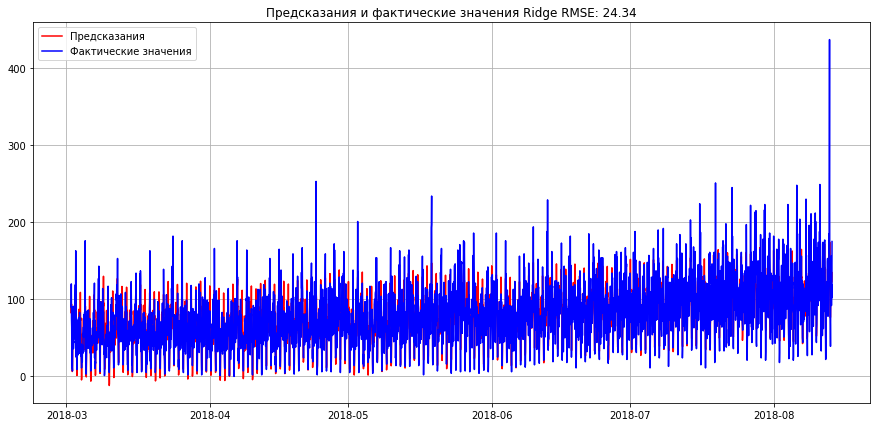

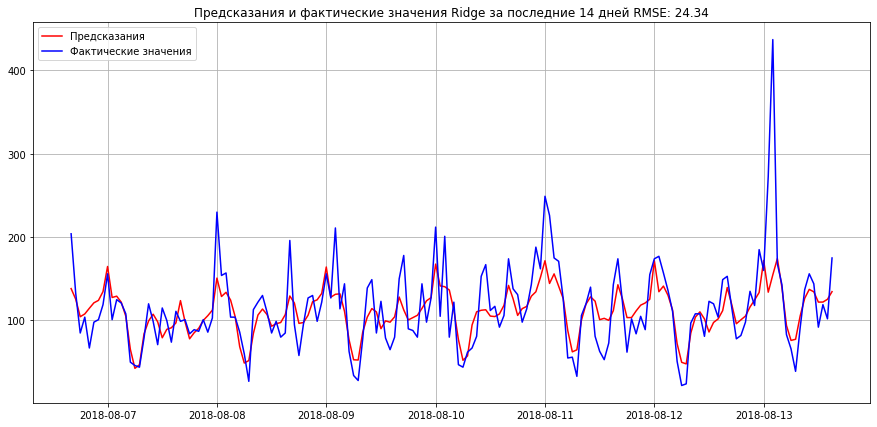

In [48]:
plot_prediction('Ridge', y_train)

#### LinearRegression

In [49]:
# Пайплайн для LinearRegression и ее параметры

model_linear = LinearRegression()

pipe_linear = make_pipeline(preprocessor_linear, model_linear)

param_linear = {}

In [50]:
%%time

best_model_linear = best_model(pipe_linear, param_linear, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 284 ms, sys: 527 ms, total: 810 ms
Wall time: 771 ms


In [51]:
results['LinearRegression']= best_model_linear
#results['LinearRegression']

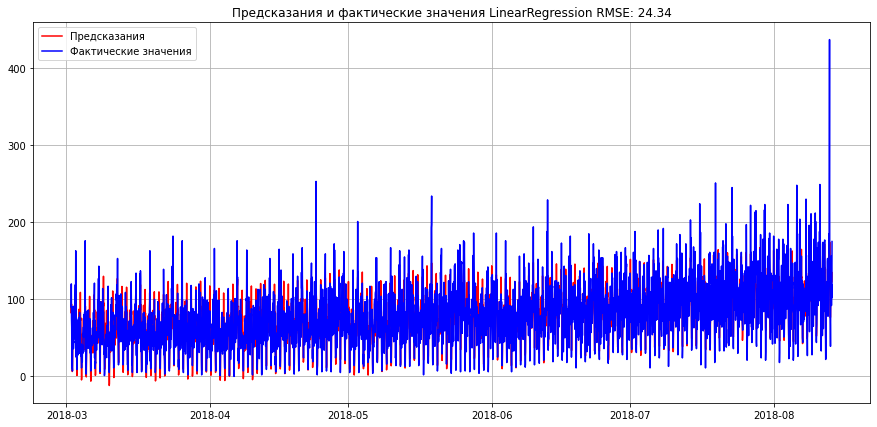

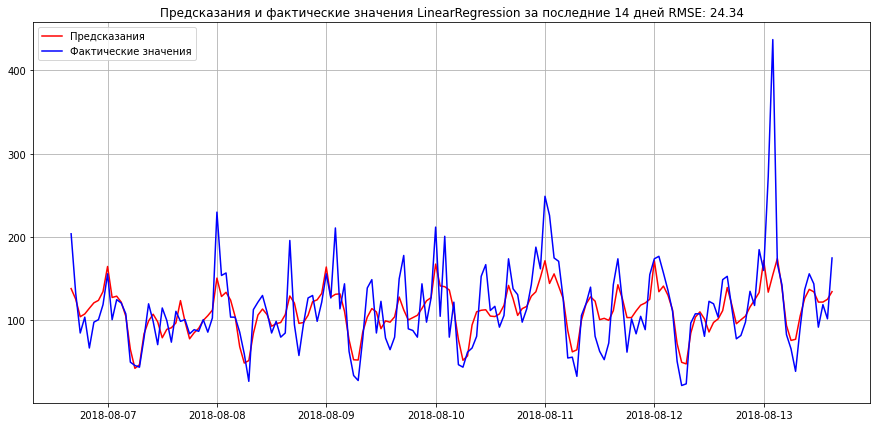

In [52]:
plot_prediction('LinearRegression', y_train)

### Вывод

Были подготовлены и обучены 4 модели с разными диапазонами гиперпараметров:  
'LGBMRegressor'  
'RandomForestRegressor'  
'Ridge'
'LinearRegression'  

Модели были обучены с помощью созданной нами функции, которая выдает модель с лучшими гиперпараметрами по заданной заказчиком метрике - RMSE, используя оптимизатор параметров RandomizedSearchCV, а также подсчитывающая время обучения лучшей модели и время ее предсказания на обучающей выборке, для общей информации.

###  Анализ моделей на обучающей выборке

In [53]:
# Результирующая таблица лучших моделей по качеству rmse
df_results = pd.DataFrame(results).T
df_results

,best_model,best_params,predict,best_score,fit_time,predict_time
LGBMRegressor,"(ColumnTransformer(remainder='passthrough',\n ...","{'lgbmregressor__n_estimators': 42, 'lgbmregre...","[103.65542672406305, 87.88202609159872, 59.095...",24.926792,0.391564,0.007668
RandomForestRegressor,"(ColumnTransformer(remainder='passthrough',\n ...","{'randomforestregressor__n_estimators': 49, 'r...","[103.04366253566927, 81.12889715212296, 81.466...",27.539391,0.282234,0.013905
Ridge,"(ColumnTransformer(remainder='passthrough',\n ...","{'ridge__solver': 'auto', 'ridge__alpha': 0.01}","[118.06095845357407, 82.04757254107177, 93.934...",24.338234,0.098526,0.092845
LinearRegression,"(ColumnTransformer(remainder='passthrough',\n ...",{},"[118.06057683435975, 82.04704839489472, 93.934...",24.336981,0.097795,0.007167


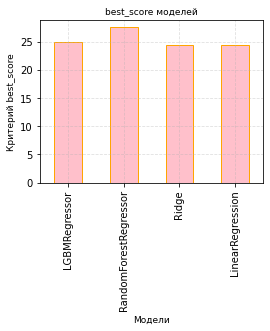

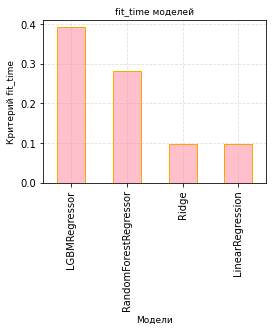

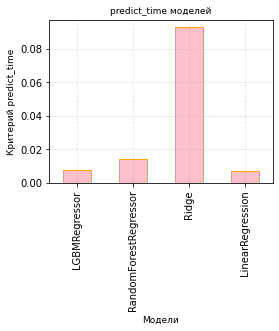

In [54]:
# Графики для сравнения критериев
try:
    list(map(lambda x:[plt.figure(figsize=(4,3)), 
                       df_results[x].plot(kind='bar', color = 'pink', ec='orange'), 
                       plt.grid(linestyle='--', alpha=0.4),
                       plt.title(f'{x} моделей', fontsize=9), 
                       plt.xlabel('Модели', fontsize=9), 
                       plt.ylabel(f'Критерий {x}', fontsize=9)], 
             list(df_results.columns[-3:])))
    plt.show()
except:
    print('Ошибка, возможно, список пуст')

In [55]:
# лучшие модели по нескольким критериям

best_score_idx = df_results['best_score'].astype(float).idxmin()
best_fit_time_idx = df_results['fit_time'].astype(float).idxmin()
best_predict_time_idx = df_results['predict_time'].astype(float).idxmin()

# параметры лучшей модели и ее значение по заданному критерию
best_score = [best_score_idx, 
              df_results.loc[best_score_idx, 'best_params'], 
              df_results.loc[best_score_idx, 'best_score'],
              df_results.loc[best_score_idx, 'best_model']
]
best_fit_time = [best_fit_time_idx, 
                 df_results.loc[best_fit_time_idx, 'best_params'], 
                 df_results.loc[best_fit_time_idx, 'fit_time'],
                 df_results.loc[best_fit_time_idx, 'best_model']
]   
best_predict_time = [best_predict_time_idx,
                     df_results.loc[best_predict_time_idx, 'best_params'],
                     df_results.loc[best_predict_time_idx, 'predict_time'],
                     df_results.loc[best_predict_time_idx, 'best_model']
]

In [56]:
# Таблица лучших моделей для каждого из критериев
df_bests = pd.DataFrame({'Критерии': ['score', 'fit_time', 'predict_time'], 
                         'Значение критерия': [round(best_score[2], 2), round(best_fit_time[2],2), 
                                               round(best_predict_time[2],2)],
                         'Имя модели': [best_score[0], best_fit_time[0], best_predict_time[0]],
                         'Гиперпараметры': [best_score[1], best_fit_time[1], best_predict_time[1]],
                         'Модель': [best_score[3], best_fit_time[3], best_predict_time[3]]
                  })
df_bests.set_index('Критерии', inplace=True)
df_bests

,Значение критерия,Имя модели,Гиперпараметры,Модель
Критерии,,,,
score,24.34,LinearRegression,{},"(ColumnTransformer(remainder='passthrough',\n ..."
fit_time,0.10,LinearRegression,{},"(ColumnTransformer(remainder='passthrough',\n ..."
predict_time,0.01,LinearRegression,{},"(ColumnTransformer(remainder='passthrough',\n ..."


In [57]:
list(map(lambda x: [
    print(f'Лучшая модель по критерию {x}:\n {df_bests.loc[x,"Имя модели"]} \n {df_bests.loc[x,"Гиперпараметры"]}\n')], 
    list(df_bests.index)))

Лучшая модель по критерию score:
 LinearRegression 
 {}

Лучшая модель по критерию fit_time:
 LinearRegression 
 {}

Лучшая модель по критерию predict_time:
 LinearRegression 
 {}



[[None], [None], [None]]

Анализ на обучающей выборке показал, что  
       
     LinearRegression 
      
подходит для анализа на тестовой выборке, т.к. у модели лучшее RMSE:   
  
LGBMRegressor - 24.923  
RandomForestRegressor - 27.54
Ridge - 24.339  
LinearRegression - 24.337

Разница меду моделями Ridge и LinearRegression в тысячные доли, LinearRegression было отдано предпочтение ввиду ее более быстрого обучения по сравнению с Ridge. Разница меду моделями Ridge и LinearRegression в тысячные доли, LinearRegression было отдано предпочтение ввиду ее более быстрого обучения по сравнению с Ridge в тысячные значения, хоть при этом скорость предсказания в Ridge больше, но всего на десятитысячные.

## Тестирование  выбранной модели

In [58]:
# Модель для тестирования - лучшая по оценке rmse на выборке train

df_bests = df_bests.loc[df_bests.index == 'score']


In [59]:
# Предсказания модели на тестовой выборке

best_predict = df_bests.loc['score', 'Модель'].predict(X_test)
#best_predict

In [60]:
# Оценка качества модели по метрике rmse

rmse_best_model = round(np.sqrt(mean_squared_error(y_test, best_predict)),0)

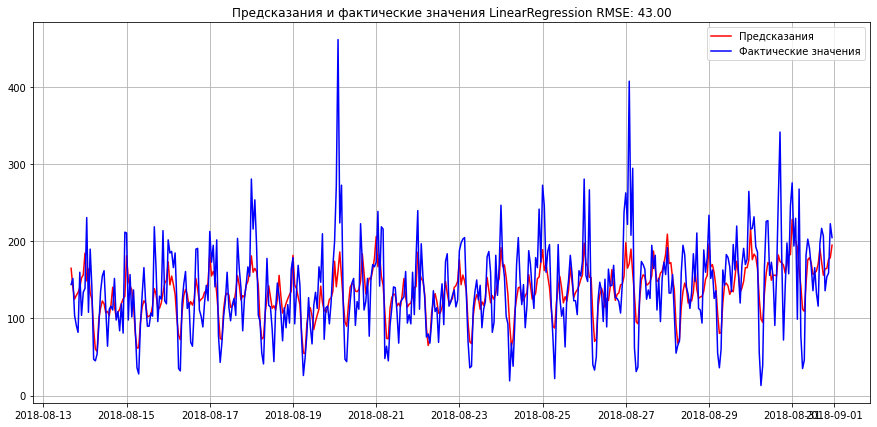

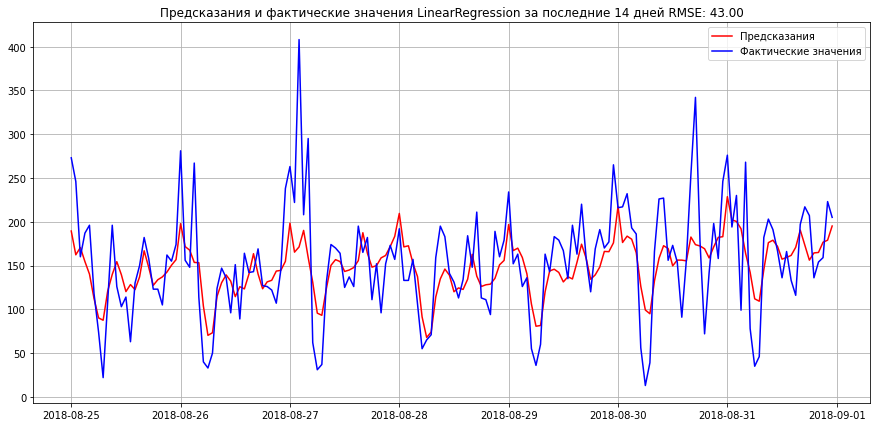

In [61]:
plot_prediction(df_bests['Имя модели'][0], y_test, sample_test=True)

Предсказания модели чуть более сглажены к фактическим значениям, характер пиков и спадов сохранен.

In [62]:
# Предсказания базовой модели на тестовой выборке 

dummy_model = make_pipeline(preprocessor_linear, DummyRegressor(strategy='mean'))
dummy_model.fit(X_train, y_train)
dummy_model_predict = dummy_model.predict(X_test)
rmse_dummy = round(np.sqrt(mean_squared_error(y_test, dummy_model_predict)),0)

,model,rmse_test
0,LinearRegression,43.0
1,DummyRegressor,85.0
2,пороговая RMSE заказчика,48.0


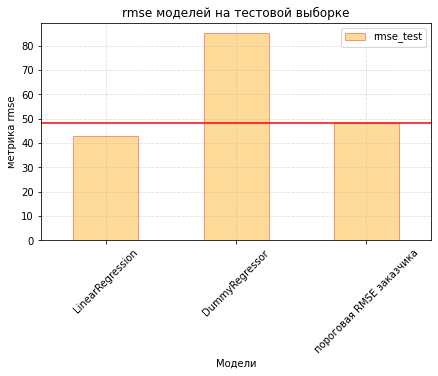

In [63]:
# rmse на тестовой выборке

rmse_dct = {'model': list(df_bests.loc[df_bests.index, 'Имя модели']) + ['DummyRegressor'] + ['пороговая RMSE заказчика'],
            'rmse_test': [rmse_best_model]+[rmse_dummy]+[POROG_TEST]
}
rmse_dct = pd.DataFrame(rmse_dct)

#rmse_dct.set_index('Модель', inplace=False)
display(rmse_dct)

ax = rmse_dct.plot(kind='bar', alpha=0.4, color='orange', ec='red', figsize=(7,4))
ax.set_xticklabels(rmse_dct.loc[:,'model'], rotation=45, fontsize=10)
ax.axhline(POROG_TEST, color='Red')
plt.grid(linestyle='--', alpha=0.4)
plt.title(f'rmse моделей на тестовой выборке', fontsize=12) 
plt.xlabel('Модели', fontsize=10) 
plt.ylabel(f'метрика rmse', fontsize=10) 
plt.show()

### Вывод 

In [64]:
# Проверка на адекватность и критерий заказчика
[print(f"Модель {df_bests.loc['score', 'Имя модели']} \n c гиперпараметрами {df_bests.loc['score', 'Гиперпараметры']}"),
  print(f" и rmse = {rmse_best_model} \n прошла порогове значение заказчика rmse={POROG_TEST} и тест на адекватность")
 if ((rmse_best_model < rmse_dummy) & (rmse_best_model < POROG_TEST))
 else print(f"Модель {df_bests.loc['score', 'Имя модели']} не прошла тест на адекватность") 
]

Модель LinearRegression 
 c гиперпараметрами {}
 и rmse = 43.0 
 прошла порогове значение заказчика rmse=48 и тест на адекватность


[None, None]

### Общий вывод 

Исходные данные содержат сумму заказов такси за 10 минут. 
Всего записей 26496.
Тип данных подходит для анализа.
Данные были ресемплированы по одному часу.  
Оставшееся количество записей сократилось до 4416.  
Данных достаточно для анализа.

Данные были изучены, ресемплированы по часу, проанализированы графики. Были найдены сезонная и трендовая составляющие, 

нестационарность (прогнозировать такой сложнее, чем стационарный). Количество заказов за рассматриваемый период имеет 

увеличивающийся тренд от месяца к месяцу: более явным он становится с приходом лета, видимо, это связано с сезоном 

отпусков: в частности, люди чаще летают и, соответственно, чаще заказывают такси. По понедельникам и четвергам спрос 

максимальный, по вторникам и воскресеньям - минимальный.  
Максимальное количество заказов около 00 часов: активный рост заказов начинается с 17 часов.   
Пик сменяется активным падением заказов: минимальное количество заказов приходится на 6 утра. 
С 7 до 10 часов рост заказов. Пики также в 16 часов. Это связано скорее всего и с расписанием прилетов.  
Ожидаемо, что в ночные часы такси пользуется спросом у клиентов.
Сформированы дополнительные признаки ввиду размера выборки для анализа и горизонта прогноза в 1 час.  

Календарные признаки - так как периодические всплески наблюдаются каждцю неделю и месяц, а в днях наблюдаются пики и 

спады.  
 номер часа в сутках  
 номер дня недели  
 выходной день   
   
скользящее среднее - оно отражает характеристики тренда  
средняя по группе час - данным признаком заменим признак hour для большей информативности при обучении  
Признаки отстающих значений  6 штук   

Всего признаков для анализа 11, т.к. hour заменен средним по группе час.    

Пропуски посе преобразований были удалены.  
Построены и проанализированы графики.   
От месяца к месяцу тренд на увеличение заказов такси.  

Максимальное количество заказов около 00 часов: активный рост заказов начинается с 17 часов.   
Пик сменяется активным падением заказов: минимальное количество заказов приходится на 6 утра. 
С 7 до 10 часов рост заказов. Пики также в 16 часов. Это связано скорее всего и с расписанием прилетов.  
Ожидаемо, что в ночные часы такси пользуется спросом у клиентов.  

Были подготовлены обучающая и тестовая выборки для обучения моделей. Выделен целевой признак 'num_orders' - количество 
заказов такси в час.
По условиям заказчика тестовая выборка составила 10% исходных данных - около 2х недель: с 2018-08-13 16:00:00 по 2018-08-
31 23:00:00.  
Размер обучающей выборки: (3952, 12)    
Размер тестовой выборки: (440, 12)
Оценена корреляция: мультиколлинеарных признаков нет.    

Были подготовлены и обучены 4 модели с разными диапазонами гиперпараметров:  
'LGBMRegressor'  
'RandomForestRegressor'  
'Ridge'
'LinearRegression'  

Модели были обучены с помощью созданной нами функции, которая выдает модель с лучшими гиперпараметрами по заданной 
заказчиком метрике - RMSE, используя оптимизатор параметров RandomizedSearchCV, а также подсчитывающая время обучения
лучшей модели и время ее предсказания на обучающей выборке, для общей информации.
Анализ на обучающей выборке показал, что LGBMRegressor подходит для анализа на тестовой выборке, т.к. у модели лучшее 

RMSE:   
  
LGBMRegressor - 24.923  
RandomForestRegressor - 27.54
Ridge - 24.339  
LinearRegression - 24.337

Разница меду моделями Ridge и LinearRegression в тысячные доли, LinearRegression было отдано предпочтение ввиду ее более быстрого обучения по сравнению с Ridge в тысячные значения, хоть при этом скорость предсказания в Ridge больше, но всего на десятитысячные.
Предсказания модели чуть более сглажены к фактическим значениям, характер пиков и спадов сохранен.

Для прогноза заказов такси на час вперед рекомендована модель   
Модель LinearRegression 
 ее rmse = 43.0  на тестовой выборке. 
 
она прошла порогове значение заказчика rmse=48 и тест на адекватность.